In [22]:
# Copyright (c) OpenMMLab. All rights reserved.
import mimetypes
import os
import time
import glob
from tqdm import tqdm
import cv2
import json_tricks as json
import mmcv
import mmengine
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples, split_instances
from mmpose.utils import adapt_mmdet_pipeline
from mmdet.apis import inference_detector, init_detector

#### Demo

##### Body

In [6]:
#################### Body ####################
# Initialize body detector
body_det_config = 'external/mmlab/mmpose/demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
body_det_ckpt = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
device = 'cuda:0'
body_detector = init_detector(body_det_config, body_det_ckpt, device=device)
body_detector.cfg = adapt_mmdet_pipeline(body_detector.cfg)

# Initialize body pose estimator
body_pose_config = 'external/mmlab/mmpose/configs/wholebody_2d_keypoint/topdown_heatmap/coco-wholebody/td-hm_vipnas-res50_dark-8xb64-210e_coco-wholebody-256x192.py'
body_pose_ckpt = 'https://download.openmmlab.com/mmpose/top_down/vipnas/vipnas_res50_wholebody_256x192_dark-67c0ce35_20211112.pth'
device = 'cuda:0'
body_pose_estimator = init_pose_estimator(body_pose_config, 
                                          body_pose_ckpt, 
                                          device=device)
body_pose_estimator.cfg = adapt_mmdet_pipeline(body_pose_estimator.cfg)
# build body pose visualizer
body_pose_estimator.cfg.visualizer.radius = 5
body_pose_estimator.cfg.visualizer.alpha = 1
body_pose_estimator.cfg.visualizer.line_width = 4 # No effect?
body_visualizer = VISUALIZERS.build(body_pose_estimator.cfg.visualizer)
body_visualizer.set_dataset_meta(
    body_pose_estimator.dataset_meta, skeleton_style='mmpose')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/vipnas/vipnas_res50_wholebody_256x192_dark-67c0ce35_20211112.pth


/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmlab/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/coco_wholebody.py" does not exist. A matched config file "/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmlab/mmpose/mmpose/.mim/configs/_base_/datasets/coco_wholebody.py" will be used instead.
  warnings.warn(


07/28 15:22:22 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


Bbox

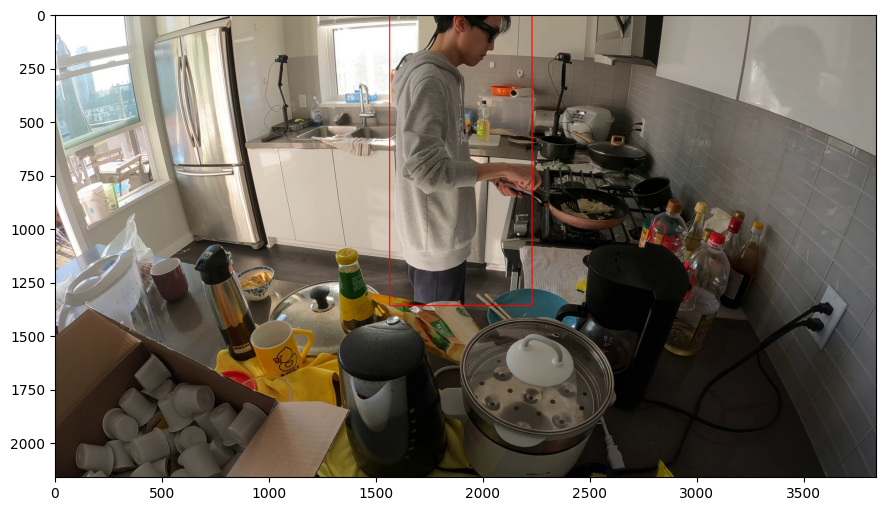

In [7]:
#####################################
test_case = "sfu_cooking_007_3"
#####################################

img_dir_path = f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/frames/cam01_0"
all_img_path = sorted(glob.glob(os.path.join(img_dir_path, '*')))
img = all_img_path[0]

######### Bbox with pretrained detector ############
body_det_result = inference_detector(body_detector, img)
body_pred_instance = body_det_result.pred_instances.cpu().numpy()
body_bboxes = np.concatenate((body_pred_instance.bboxes, body_pred_instance.scores[:, None]), axis=1)

# Manually select first two bboxes
body_bbox = body_bboxes[:1,:4] # Get first two bboxes

# Visualization
image = np.array(Image.open(img))
bbox_vis = body_bbox.astype(np.int64)
for curr_vis_bbox in bbox_vis:
    cv2.rectangle(image, curr_vis_bbox[:2], curr_vis_bbox[2:], color=(255,0,0), thickness=3);
plt.figure(figsize=(15,6))
plt.imshow(image)

Pose2d

In [9]:
body_pose_results = inference_topdown(body_pose_estimator, img, body_bbox)
body_data_samples = merge_data_samples(body_pose_results)

# Extract hand pose2d kpts array
body_kpts = body_data_samples.pred_instances.keypoints
body_kpts_conf = body_data_samples.pred_instances.keypoint_scores

# Final result
body_pose2d_result = np.append(body_kpts, body_kpts_conf[:,:,None], axis=2)

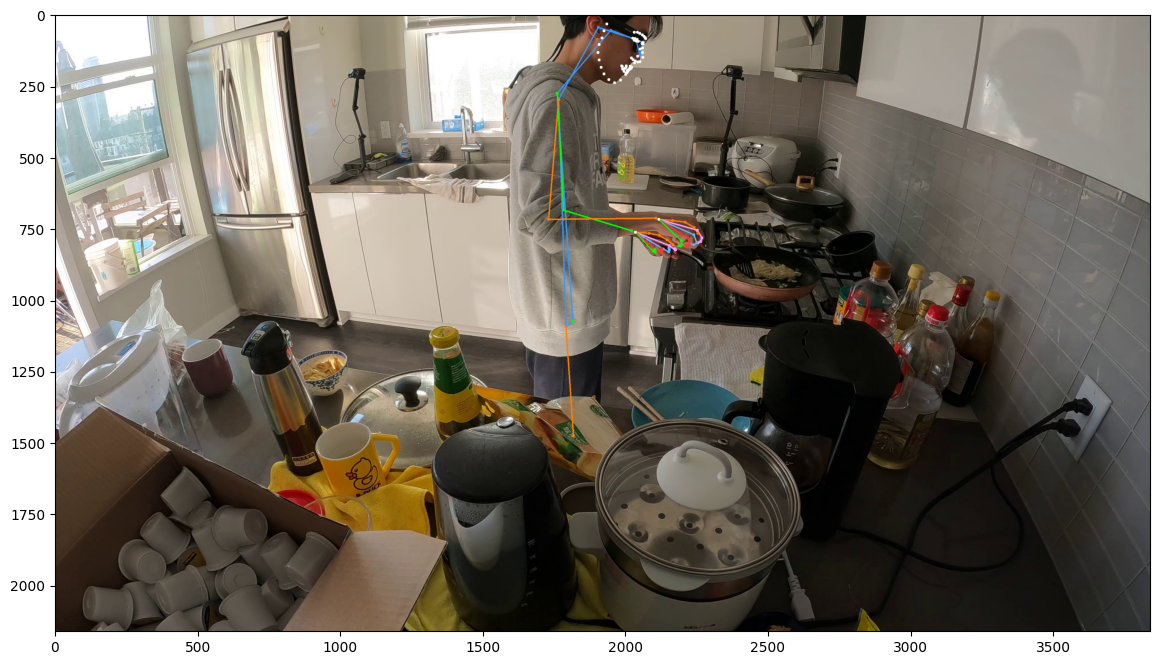

In [20]:
########### Visualization ############
image = np.array(Image.open(img))
body_pose_vis = body_visualizer.add_datasample(
    'result',
    image,
    data_sample=body_data_samples,
    draw_gt=False,
    draw_heatmap=False,
    draw_bbox=False,
    show_kpt_idx=False,
    skeleton_style='mmpose',
    show=False,
    wait_time=0,
    kpt_thr=0.3)

plt.figure(figsize=(15,8))
plt.imshow(body_pose_vis)

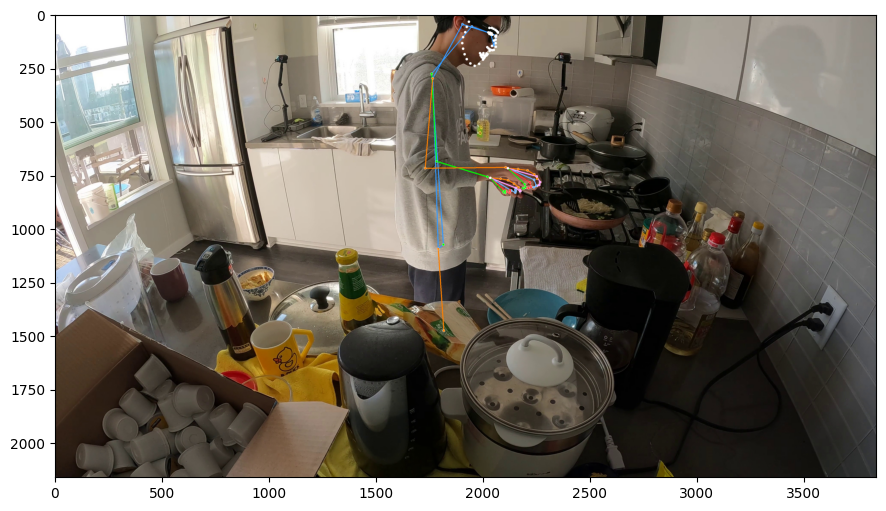

In [10]:
######## Visualization with mmpose Fastvisualizer #########
from mmpose.visualization import FastVisualizer
from mmengine.structures import InstanceData

fast_visualizer = FastVisualizer(body_pose_estimator.dataset_meta)

# Inference
vis_img = np.array(Image.open(img))
####### Create InstanceData #######
instanceData = InstanceData()
instanceData.keypoints = body_kpts.copy()
instanceData.keypoint_scores = body_kpts_conf.copy()
###################################

fast_visualizer.draw_pose(vis_img, instanceData)
plt.figure(figsize=(15,6))
plt.imshow(vis_img)

##### Hand

In [23]:
#################### Hand ####################
# Intitalize hand detector
hand_det_config = 'external/mmlab/mmpose/projects/rtmpose/rtmdet/hand/rtmdet_nano_320-8xb32_hand.py'
hand_det_ckpt = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth'
device = 'cuda:0'
hand_detector = init_detector(hand_det_config, hand_det_ckpt, device=device)
hand_detector.cfg = adapt_mmdet_pipeline(hand_detector.cfg)

# Initialize hand pose estimator
hand_pose_config = 'external/mmlab/mmpose/projects/rtmpose/rtmpose/hand_2d_keypoint/rtmpose-m_8xb32-210e_coco-wholebody-hand-256x256.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth'
hand_pose_estimator = init_pose_estimator(
    hand_pose_config,
    hand_pose_ckpt,
    device=device,
    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))))
# build hand pose visualizer
hand_pose_estimator.cfg.visualizer.radius = 3
hand_pose_estimator.cfg.visualizer.alpha = 0.8
hand_pose_estimator.cfg.visualizer.line_width = 4
hand_visualizer = VISUALIZERS.build(hand_pose_estimator.cfg.visualizer)
hand_visualizer.set_dataset_meta(
    hand_pose_estimator.dataset_meta, skeleton_style='mmpose')

07/28 16:24:38 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_nano_8xb32-300e_hand-267f9c8f.pth
07/28 16:24:38 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmlab/mmpose/mmpose/datasets/datasets/utils.py:102: UserWarning: The metainfo config file "configs/_base_/datasets/onehand10k.py" does not exist. A matched config file "/home/jinxu/code/Ego4d_mmpose/Ego4d/ego4d/internal/human_pose/external/mmlab/mmpose/mmpose/.mim/configs/_base_/datasets/onehand10k.py" will be used instead.
  warnings.warn(
/home/jinxu/miniconda3/envs/human_pose_mmpose/lib/python3.9/site-packages/mmdet/apis/inference.py:108: UserWarning: palette does not exist, random is used by default. You can also set the palette to customize.
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-hand5_pt-aic-coco_210e-256x256-74fb594_20230320.pth


/home/jinxu/miniconda3/envs/human_pose_mmpose/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


Bbox

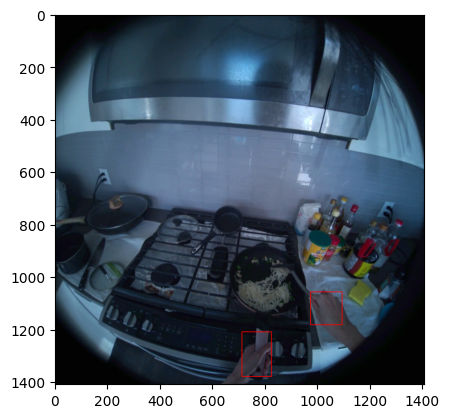

In [26]:
#####################################
test_case = "sfu_cooking_007_3_18060-18210"
#####################################

img_dir_path = f"/media/jinxu/New Volume/ego4dData/cache/{test_case}/frames/aria01_rgb"
all_img_path = sorted(glob.glob(os.path.join(img_dir_path, '*')))
img = all_img_path[68]

# Inference
hand_det_result = inference_detector(hand_detector, img)
hand_pred_instance = hand_det_result.pred_instances.cpu().numpy()
hand_bboxes = np.concatenate((hand_pred_instance.bboxes, hand_pred_instance.scores[:, None]), axis=1)
# bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > 0.3)]
# bboxes = bboxes[nms(bboxes, 0.3), :4]

# Manually select first two bboxes
hand_bbox = hand_bboxes[:2,:4] # Get first two bboxes

# Visualization
image = np.array(Image.open(img))
plt.imshow(image)
bbox_vis = hand_bbox.astype(np.int64)
for curr_vis_bbox in bbox_vis:
    cv2.rectangle(image, curr_vis_bbox[:2], curr_vis_bbox[2:], color=(255,0,0), thickness=2);
plt.imshow(image)

Pose2d

In [32]:
hand_pose_results = inference_topdown(hand_pose_estimator, img, hand_bbox)
hand_data_samples = merge_data_samples(hand_pose_results)

# Extract hand pose2d kpts array
hand_kpts = hand_data_samples.pred_instances.keypoints
hand_kpts_conf = hand_data_samples.pred_instances.keypoint_scores

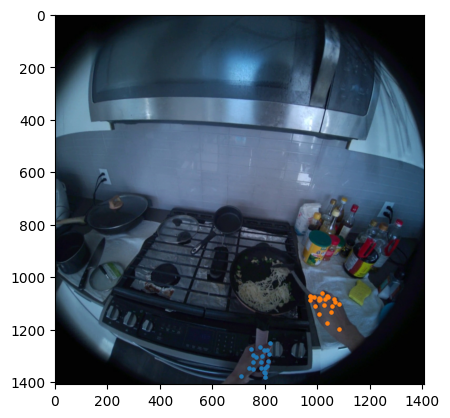

In [28]:
# Scatter plot of hand kpts
image = np.array(Image.open(img))
hand_vis_kpts = hand_kpts.astype(np.int64)
for curr_hand_kpt in hand_vis_kpts:
    plt.scatter(curr_hand_kpt[:,0], curr_hand_kpt[:,1], s=5)
plt.imshow(image)

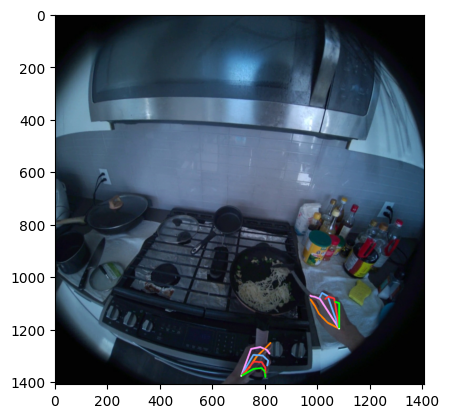

In [38]:
########### Visualization ############
hand_pose_vis = hand_visualizer.add_datasample(
    'result',
    image,
    data_sample=hand_data_samples,
    draw_gt=False,
    draw_heatmap=False,
    draw_bbox=False,
    show_kpt_idx=False,
    skeleton_style='mmpose',
    show=False,
    wait_time=0,
    kpt_thr=0.3)

plt.figure()
plt.imshow(hand_pose_vis)

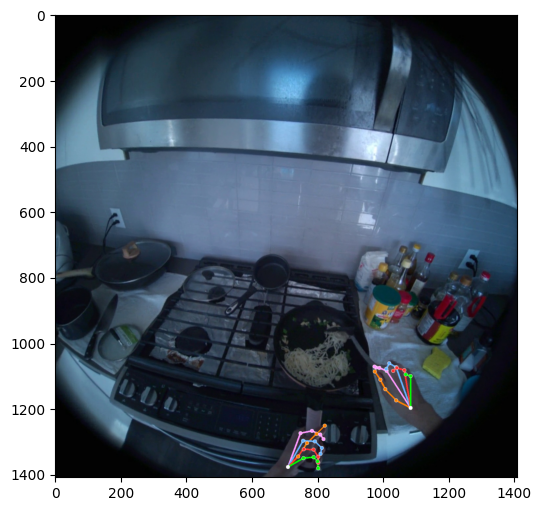

In [42]:
######## Visualization with mmpose Fastvisualizer #########
from mmpose.visualization import FastVisualizer
from mmengine.structures import InstanceData

fast_visualizer = FastVisualizer(hand_pose_estimator.dataset_meta)

# Inference
vis_img = np.array(Image.open(img))
####### Create InstanceData #######
instanceData = InstanceData()
instanceData.keypoints = hand_kpts.copy()
instanceData.keypoint_scores = hand_kpts_conf.copy()
###################################

fast_visualizer.draw_pose(vis_img, instanceData)
plt.figure(figsize=(15,6))
plt.imshow(vis_img)